# Imports

In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 36.3 MB/s eta 0:00:00


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

# Part A (الف)

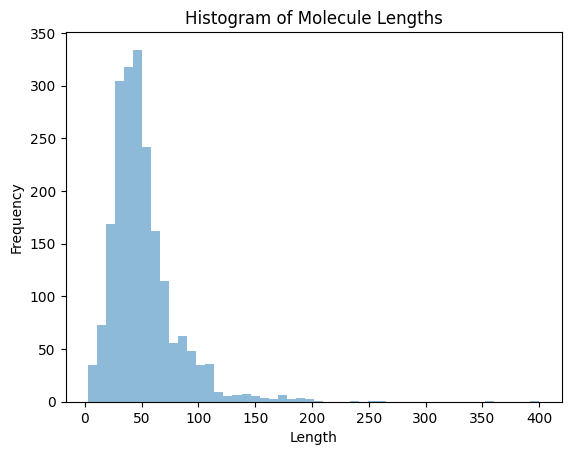

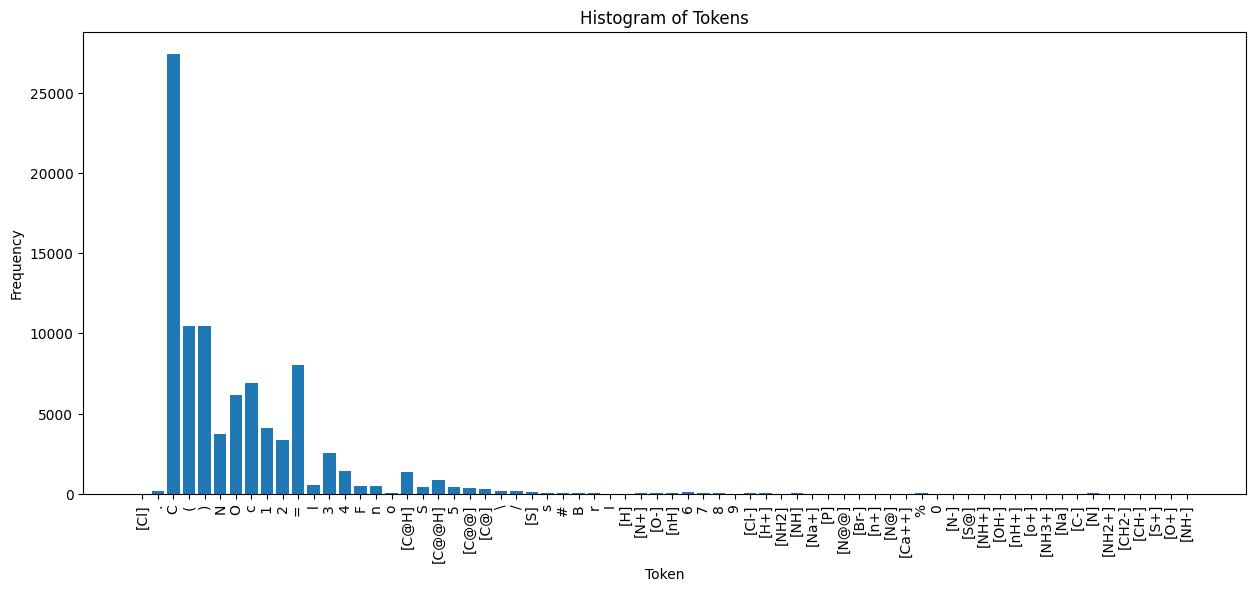

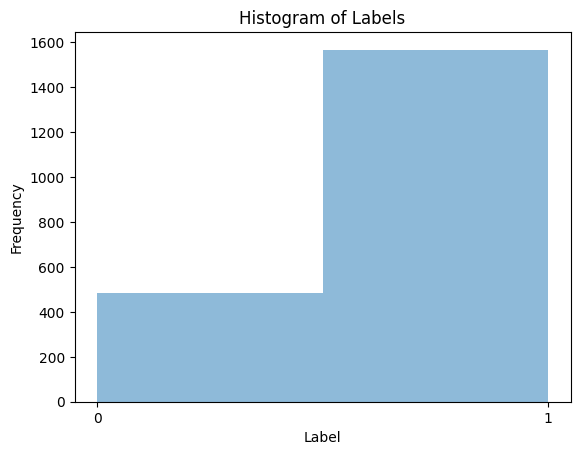

In [13]:
# Load the data
data = pd.read_csv('BBBP.csv')


# Task 1: Plot a histogram of the length of the molecules names in the column 'smiles'.
data['smiles_length'] = data['smiles'].apply(len)
plt.hist(data['smiles_length'], bins=50, alpha=0.5)
plt.title('Histogram of Molecule Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Task 2: Plot a histogram of the tokens in the smiles.
def split_smiles(smiles):
    return re.findall(r'\[.*?\]|\S', smiles)



data['tokens'] = data['smiles'].apply(split_smiles)
all_tokens = [token for sublist in data['tokens'].tolist() for token in sublist]
counter = Counter(all_tokens)


plt.figure(figsize=(15, 6))  # Increase figure size
plt.bar(counter.keys(), counter.values())
plt.title('Histogram of Tokens')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate labels by 90 degrees
plt.show()



# Task 3: Plot the histogram of the label to see if the classes are balanced or not.
plt.hist(data['p_np'], bins=2, alpha=0.5)
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()


# Part B (ب)

In [27]:
from sklearn.preprocessing import OneHotEncoder

# Get a list of all unique tokens
tokens = list(counter.keys())

# Create a dictionary mapping each token to a unique index
token_index = {token: i for i, token in enumerate(tokens)}

# Function to encode a sequence into a multiple hot vector
def encode_sequence(seq):
    vector = np.zeros(len(tokens))
    for token in seq:
        vector[token_index[token]] = 1
    return vector

data['vector'] = data['tokens'].apply(encode_sequence)


# 1. Create balanced train and test sets
data['p_np'] = data['p_np'].astype(int)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['p_np'])


In [15]:

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class VectorDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(np.array(data['vector'].values.tolist()), dtype=torch.float32).to(device)  # Move data to GPU
        self.labels = torch.tensor(data['p_np'].values, dtype=torch.float32).to(device)  # Move labels to GPU

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataloader = DataLoader(VectorDataset(train_data), batch_size=32, shuffle=True)
test_dataloader = DataLoader(VectorDataset(test_data), batch_size=32, shuffle=True)

# 2. Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(64, 1)  # Output is a single probability for BCELoss

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.layer2(x))  # Sigmoid activation for BCELoss
        return x

model_mlp = MLP(train_data['vector'].iloc[0].size).to(device)  # Move model to GPU

# 3. Define the train and test functions
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    for batch in dataloader:
        vectors, labels = batch
        optimizer.zero_grad()
        outputs = model(vectors).view(-1)  # Reshape for BCELoss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss/len(dataloader)

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            vectors, labels = batch
            outputs = model(vectors).view(-1)  # Reshape for accuracy calculation
            predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


criterion = nn.BCELoss().to(device)  # Move criterion to GPU
optimizer = Adam(model_mlp.parameters(), lr=1e-3)

# Now you can train and test your model
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train(model_mlp, train_dataloader, criterion, optimizer)
    train_acc = test(model_mlp, train_dataloader)
    test_acc = test(model_mlp, test_dataloader)
    print(50*'#')
    print(f'epoch {epoch+1} \ntraining loss: {train_loss}\ntraining accuracy: {train_acc}\ntest accuracy: {test_acc}')


##################################################
epoch 1 
training loss: 0.592825741148912
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 2 
training loss: 0.5188415308411305
training accuracy: 0.7646341463414634
test accuracy: 0.7658536585365854
##################################################
epoch 3 
training loss: 0.4621300599895991
training accuracy: 0.7920731707317074
test accuracy: 0.8195121951219512
##################################################
epoch 4 
training loss: 0.4357512564613269
training accuracy: 0.8158536585365853
test accuracy: 0.8268292682926829
##################################################
epoch 5 
training loss: 0.41026276264053124
training accuracy: 0.8158536585365853
test accuracy: 0.8365853658536585
##################################################
epoch 6 
training loss: 0.396395090680856
training accuracy: 0.8176829268292682
test accuracy: 0.8414634146341463
#####

# Part C (ج)

In [16]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(np.array(tokens).reshape(-1, 1))

class SequenceDataset(Dataset):
    def __init__(self, data, encoder):
        self.sequences = [torch.tensor(encoder.transform(np.array(seq).reshape(-1, 1)), dtype=torch.float32) for seq in data['tokens']]
        self.labels = torch.tensor(data['p_np'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

    @staticmethod
    def collate_fn(batch):
        sequences, labels = zip(*batch)
        sequences = pad_sequence(sequences, batch_first=True)
        labels = torch.tensor(labels, dtype=torch.float32)
        return sequences, labels

# Create the DataLoaders with the new collate_fn
batch_size = 12
train_dataloader = DataLoader(SequenceDataset(train_data, encoder), batch_size=batch_size, collate_fn=SequenceDataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(SequenceDataset(test_data, encoder), batch_size=batch_size, collate_fn=SequenceDataset.collate_fn, shuffle=True)


In [17]:
# Define the LSTM + MLP model
class LSTM_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_MLP, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)  # Adjusted batch size
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size).to(device)  # Adjusted batch size
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = nn.functional.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out

model_lstm = LSTM_MLP(len(tokens), 128, 1).to(device)  # Move model to GPU

# Define the train and test functions
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    for batch in dataloader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
       # print(f'seq_shape: {sequences.shape}, \nlabel_shape{labels.shape}')
        optimizer.zero_grad()
        outputs = model(sequences).view(-1)  # Reshape for BCELoss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss/len(dataloader)

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).view(-1)  # Reshape for accuracy calculation
            predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

criterion = nn.BCELoss().to(device)  # Move criterion to GPU
optimizer = Adam(model_lstm.parameters(), lr=1e-3)

# Now you can train and test your model
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train(model_lstm, train_dataloader, criterion, optimizer)
    train_acc = test(model_lstm, train_dataloader)
    test_acc = test(model_lstm, test_dataloader)
    print(50*'#')
    print(f'epoch {epoch+1} \ntraining loss: {train_loss}\ntraining accuracy: {train_acc}\ntest accuracy: {test_acc}')


##################################################
epoch 1 
training loss: 0.5668669079777098
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 2 
training loss: 0.5471178883836217
training accuracy: 0.774390243902439
test accuracy: 0.7853658536585366
##################################################
epoch 3 
training loss: 0.5260050595894347
training accuracy: 0.7932926829268293
test accuracy: 0.8097560975609757
##################################################
epoch 4 
training loss: 0.5087966834106584
training accuracy: 0.7951219512195122
test accuracy: 0.7902439024390244
##################################################
epoch 5 
training loss: 0.49650433235359887
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 6 
training loss: 0.5560735457570013
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
####

# Part D (د)

In [18]:
class BiLSTM_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM_MLP, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, 128)  # Multiply by 2 for BiLSTM
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    def forward(self, x):
        h0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(device)  # Multiply by 2 for BiLSTM
        c0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(device)  # Multiply by 2 for BiLSTM
        out, _ = self.bilstm(x, (h0, c0))
        out = out[:, -1, :]
        out = nn.functional.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out

model_bilstm = BiLSTM_MLP(len(tokens), 128, 1).to(device)  # Move model to GPU

# Define the train and test functions
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0
    for batch in dataloader:
        sequences, labels = batch
        sequences, labels = sequences.to(device), labels.to(device)
       # print(f'seq_shape: {sequences.shape}, \nlabel_shape{labels.shape}')
        optimizer.zero_grad()
        outputs = model(sequences).view(-1)  # Reshape for BCELoss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss/len(dataloader)

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).view(-1)  # Reshape for accuracy calculation
            predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

criterion = nn.BCELoss().to(device)  # Move criterion to GPU
optimizer = Adam(model_bilstm.parameters(), lr=1e-3)

# Now you can train and test your model
num_epochs = 150
for epoch in range(num_epochs):
    train_loss = train(model_bilstm, train_dataloader, criterion, optimizer)
    train_acc = test(model_bilstm, train_dataloader)
    test_acc = test(model_bilstm, test_dataloader)
    print(50*'#')
    print(f'epoch {epoch+1} \ntraining loss: {train_loss}\ntraining accuracy: {train_acc}\ntest accuracy: {test_acc}')


##################################################
epoch 1 
training loss: 0.5714122123309295
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 2 
training loss: 0.5462431418199609
training accuracy: 0.7871951219512195
test accuracy: 0.7853658536585366
##################################################
epoch 3 
training loss: 0.5557585384723914
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 4 
training loss: 0.5554558704369259
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 5 
training loss: 0.5492374467371154
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
##################################################
epoch 6 
training loss: 0.5496918389396946
training accuracy: 0.7646341463414634
test accuracy: 0.7634146341463415
####

# Part (ز, و)

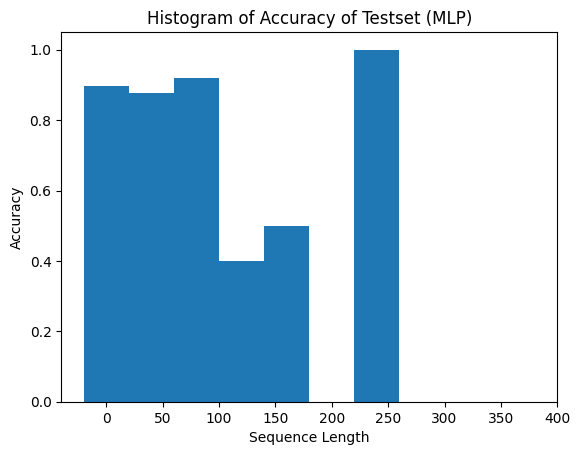

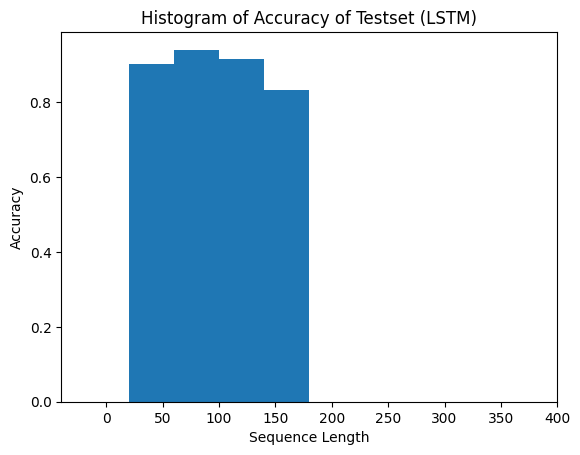

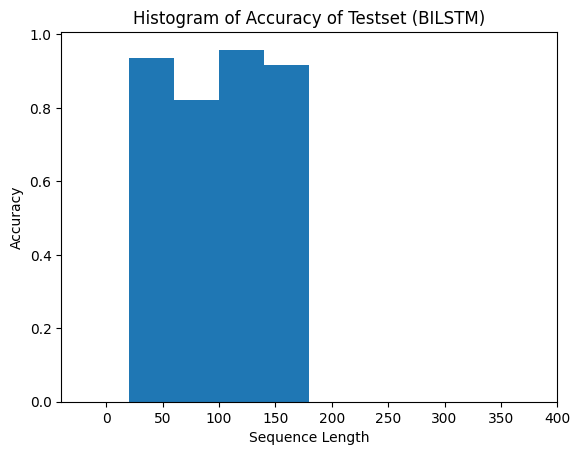

In [34]:
class VectorDataset1(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(np.array(data['vector'].values.tolist()), dtype=torch.float32).to(device)  # Move data to GPU
        self.labels = torch.tensor(data['p_np'].values, dtype=torch.float32).to(device)  # Move labels to GPU
        self.lengths = torch.tensor(data['smiles_length'].values, dtype=torch.int64).to(device)  # Move lengths to GPU

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.lengths[idx]

test_dataloader_mlp = DataLoader(VectorDataset1(test_data), batch_size=32, shuffle=True)
test_dataloader_lstm_bilstm = DataLoader(SequenceDataset(test_data, encoder), batch_size=batch_size, collate_fn=SequenceDataset.collate_fn, shuffle=True)


def test_mpl(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    correct = [0]*10
    total = [0]*10
    with torch.no_grad():
        for batch in dataloader:
            vectors, labels, length = batch
            vectors = vectors.to(device)
            length = length.to(device)
            labels = labels.to(device)
            outputs = model(vectors).view(-1)
            predicted = (outputs > 0.5).float()
            for i in range(len(labels)):
                index = min(length[i]//40, 9)
                total[index] += 1
                correct[index] += (predicted[i] == labels[i]).item()
    accuracy = [correct[i] / total[i] if total[i] != 0 else 0 for i in range(10)]


    plt.bar(range(0, 400, 40), accuracy, width=40)
    plt.xlabel('Sequence Length')
    plt.ylabel('Accuracy')
    plt.title('Histogram of Accuracy of Testset (MLP)')
    plt.show()



def test_lstm(model, dataloader, name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    correct = [0]*10
    total = [0]*10
    with torch.no_grad():
        for batch in dataloader:
            vectors, labels = batch
            vectors = vectors.to(device)
            labels = labels.to(device)
            outputs = model(vectors).view(-1)
            predicted = (outputs > 0.5).float()
            for i in range(len(labels)):
                index = min(len(vectors[i])//40, 9)
                total[index] += 1
                correct[index] += (predicted[i] == labels[i]).item()
    accuracy = [correct[i] / total[i] if total[i] != 0 else 0 for i in range(10)]


    plt.bar(range(0, 400, 40), accuracy, width=40)

    plt.xlabel('Sequence Length')
    plt.ylabel('Accuracy')
    plt.title(f'Histogram of Accuracy of Testset ({name})')
    plt.show()



test_mpl(model_mlp, test_dataloader_mlp)

test_lstm(model_lstm, test_dataloader_lstm_bilstm, 'LSTM')

test_lstm(model_bilstm, test_dataloader_lstm_bilstm, 'BILSTM')


# Explanation:

The histograms above illustrate the performance of LSTM, BiLSTM, and MLP models as the sequence length increases. It's evident that both LSTM and BiLSTM models outperform the MLP model due to their recurrent nature.

Take a closer look at the bin of length [100, 160]. Here, the accuracy of the MLP model is lower than that of the LSTM and BiLSTM models. Interestingly, the BiLSTM model shows higher accuracy than the LSTM model. This can be attributed to the BiLSTM model's ability to consider future data in addition to past data, thanks to its backward pass. This result is particularly noticeable in the bins within the range of 50 to 100.

**Note**: A significant portion of the sequence lengths fall within the range of [40, 110]. the MLP model performs better for smaller lengths. However, it's important to note that the number of molecules in this range is relatively low, making it an invalid range for performance evaluation.
